## Loading everything and compute

The trajectory file for this example is available at: ...

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..") # Adds higher directory to python modules path.
sys.path.append("../..") 


import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from ase import io
from ase.visualize import view

import os
import numpy as np


from fande.data import FandeDataModule
from fande.data import create_dump_directory
from fande.data import AttrDict

soap_params = {
    'species': ["H", "C", "O"],
    'periodic': False,
    'rcut': 5.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10
}

hparams = {
    'root_dir' : os.path.abspath( os.getcwd() ),
    'dump_dir' : create_dump_directory(),
    "soap_params" : soap_params,
    'dtype' : 'float64',
    'device' : 'gpu',
    'wb' : True
}
hparams = AttrDict.from_nested_dicts(hparams)

FandeDataModule.cd_to_root_dir(hparams)
print(os.getcwd())

prefix = "data/dump/store/"

traj, descriptors, derivatives = FandeDataModule.calculate_invariants(
        traj_file = prefix+"mol_traj_300K_randrot.xyz",
        index="5000:7000", 
        positions = (0, 1, 4, 5)
        )

traj, energies, forces = FandeDataModule.calculate_energies_forces(
        traj_file = prefix+"mol_traj_300K_randrot.xyz",
        index="5000:7000")

fande.models module imported...
FandE-GP imported  
objects of fande.data module imported...
Created directory to store computational data:
/home/dlb/coding/shared_coding/repos/fande-gp/fande-notebooks/data/dump/03_06_2022_12:00:33.305002
All the artifacts are saved there.
/home/dlb/coding/shared_coding/repos/fande-gp/fande-notebooks
Total length of MD traj is 2000
Starting SOAP calculation...
SOAP calculation done!
Total length of MD traj is 2000


2000it [00:09, 218.84it/s]

Energies/forces were calculated


In [52]:
fdm = FandeDataModule(hparams)
fdm.prepare_torch_dataset(energies, forces, descriptors, derivatives)

Train set
Shape:  torch.Size([59200, 720]) torch.Size([59200])
Type:  torch.float64 torch.float64
Device:  cpu cpu

Test set
Shape:  torch.Size([14800, 720]) torch.Size([14800])
Type:  torch.float64 torch.float64
Device:  cpu cpu


## Train GP model

##### Train forces

In [59]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_X = fdm.train_X
train_Y = fdm.train_Y
test_X = fdm.test_X
test_Y = fdm.test_Y

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

ind_slice = np.sort(  np.random.choice(np.arange(0,59200), 2000, replace=False) ) 


train_dataset = TensorDataset(train_X[ind_slice], train_Y[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_X[ind_slice], train_Y[ind_slice], hparams, 0.05)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=300, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                                                   | Type                       | Params
------------------------------------------------------------------------------------------------------
0 | likelihood                                             | GaussianLikelihood         | 1     
1 | likelihood.noise_covar                                 | HomoskedasticNoise         | 1     
2 | likelihood.noise_covar.raw_noise_constraint            | GreaterThan                | 0     
3 | likelihood.noise_covar.raw_noise_constraint._transform | Softplus                   | 0     
4 | model                                                  | ExactGPModelForces         | 2     
5 | model.mean_module                                      | ZeroMean                   | 0     
6 | model.covar_module                                     | Linea


 setup() callback called...
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s, loss=-0.273, v_num=2] 

 teardown() callback called...


##### Train energies

In [60]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
import numpy as np

from pytorch_lightning import Trainer

from fande.utils import get_vectors_e

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.INFO) # logging.ERROR to disable or INFO

# get only descriptors without derivatives and energies
# train_x_e, train_y_e = get_vectors_e(train_X, train_Y, 1600, 12)

train_x_e, train_y_e = fdm.train_X_e, fdm.train_Y_e

train_x_e = train_x_e[:, :]
train_x_e, train_y_e = train_x_e.cuda(), train_y_e.cuda()

ind_slice = np.sort(  np.random.choice(np.arange(0,1600), 1600, replace=False) )

train_dataset = TensorDataset(train_x_e, train_y_e)
train_loader = DataLoader(train_dataset, batch_size=59200)

model_e = ModelEnergies(train_x_e, train_y_e, fdm, hparams, 0.05)

trainer_e = Trainer(
    gpus=1, 
    max_epochs=250, 
    precision=64, 
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_e.fit(model_e, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                                                      | Type                       | Params
----------------------------------------------------------------------------------------------------------
0  | likelihood                                                | GaussianLikelihood         | 1     
1  | likelihood.noise_covar                                    | HomoskedasticNoise         | 1     
2  | likelihood.noise_covar.raw_noise_constraint               | GreaterThan                | 0     
3  | likelihood.noise_covar.raw_noise_constraint._transform    | Softplus                   | 0     
4  | model                                                     | ExactGPModelEnergies       | 722   
5  | model.mean_module                                         | ZeroMean                   | 0     
6  | model.covar_module           


 setup() callback called...
Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, loss=-1.76, v_num=3] 

 teardown() callback called...


## Check predictions on test dataset

In [58]:
from ase.visualize import view

view(traj[0])

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.




 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


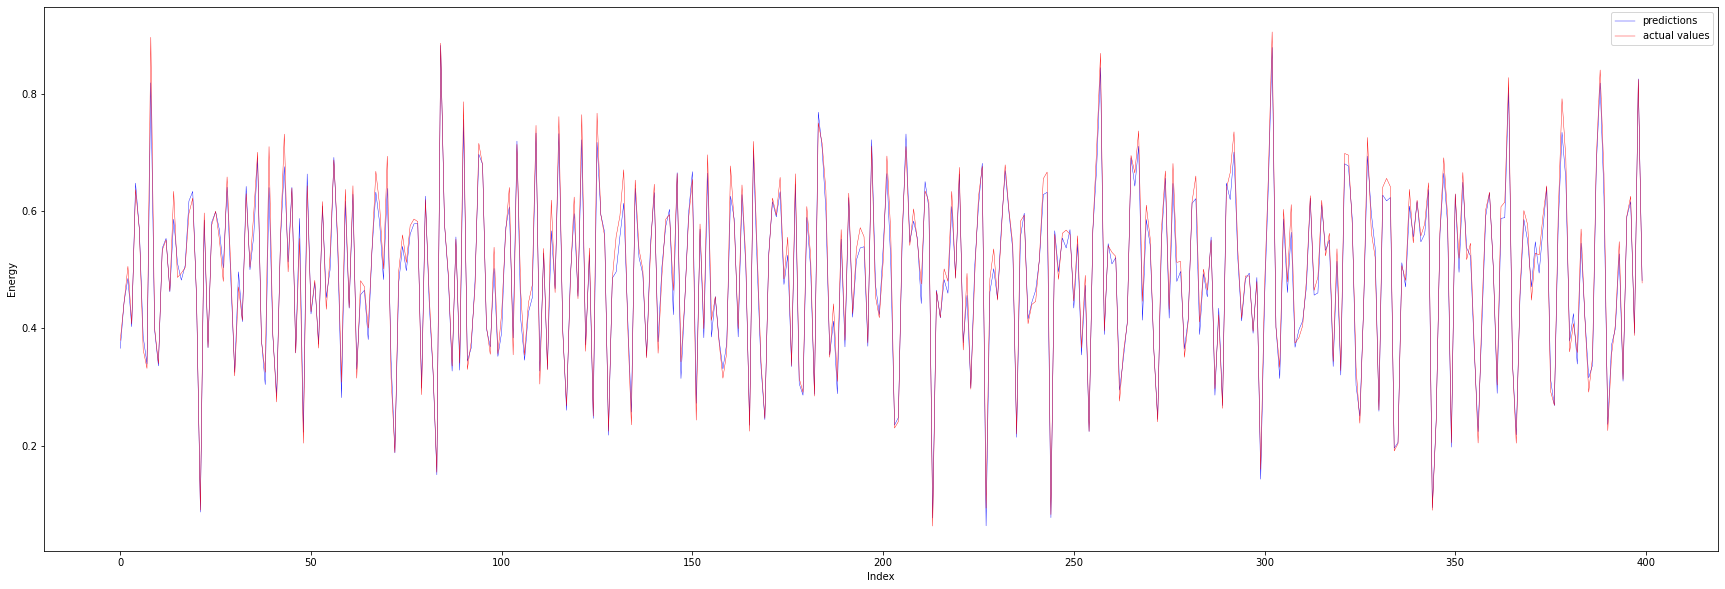

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.




Energies MAE: 0.0152
Energies MSE: 0.0004

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


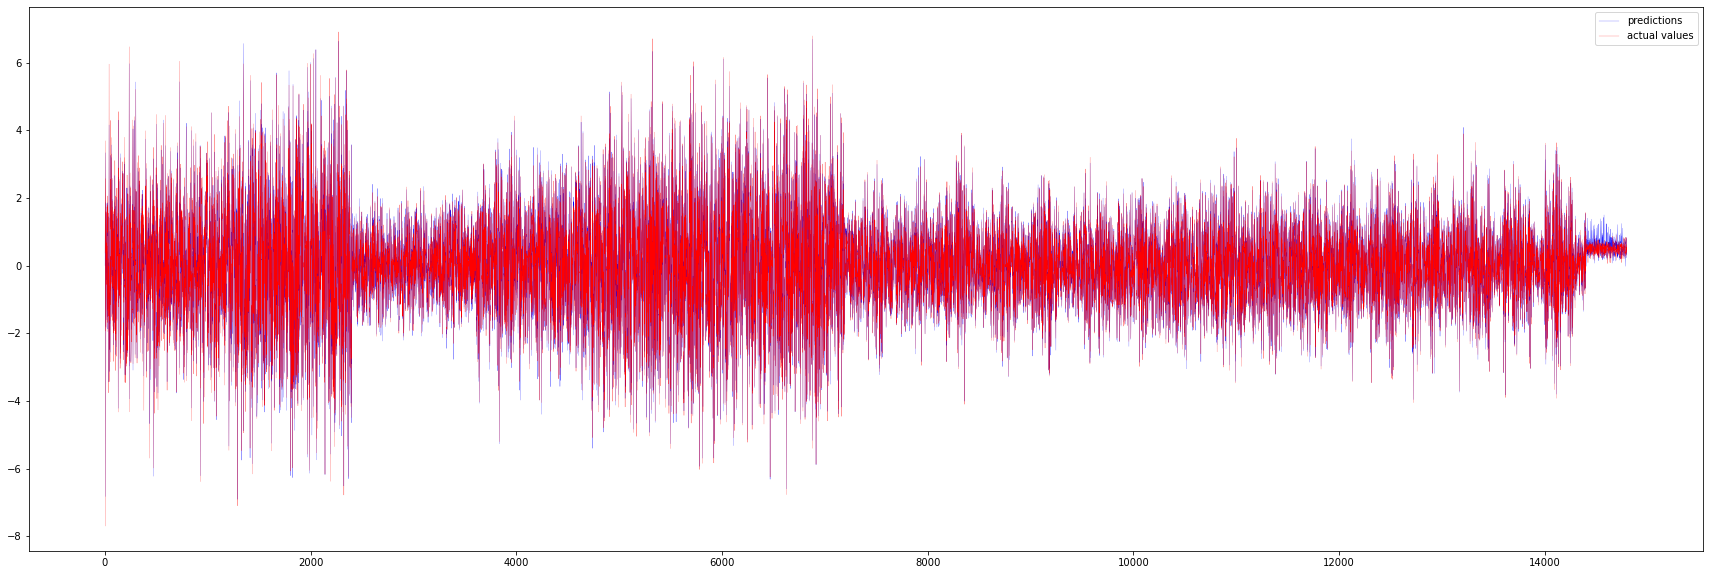

0.8


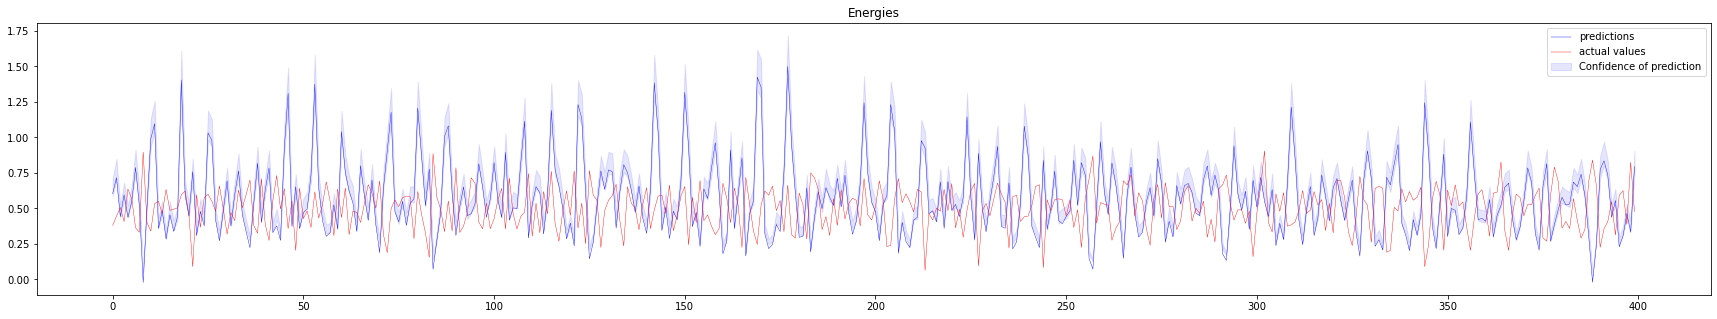

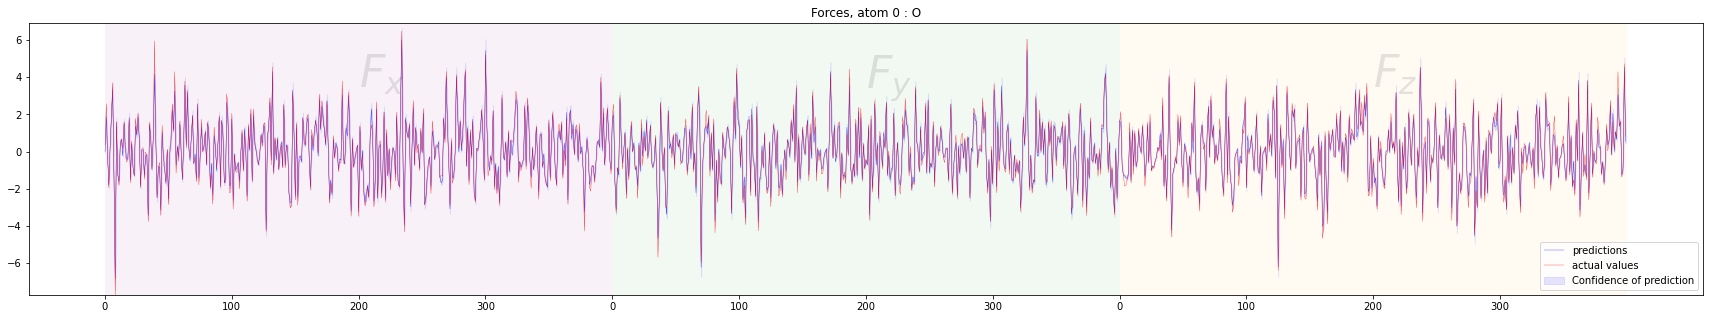

Forces MAE: 0.1947
Forces MSE: 0.0701
Cumulative uncertainty: 126.5572


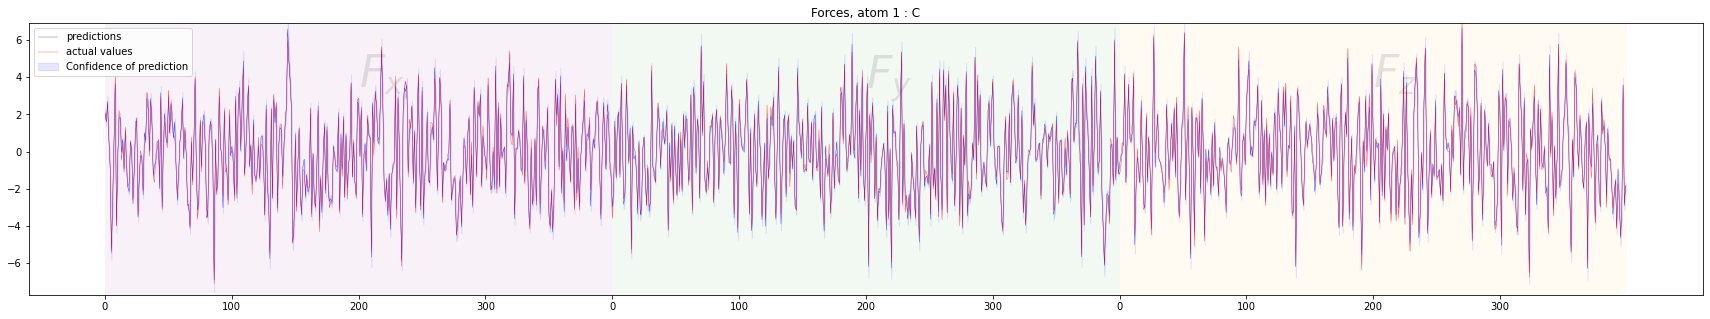

Forces MAE: 0.2400
Forces MSE: 0.0925
Cumulative uncertainty: 83.4035


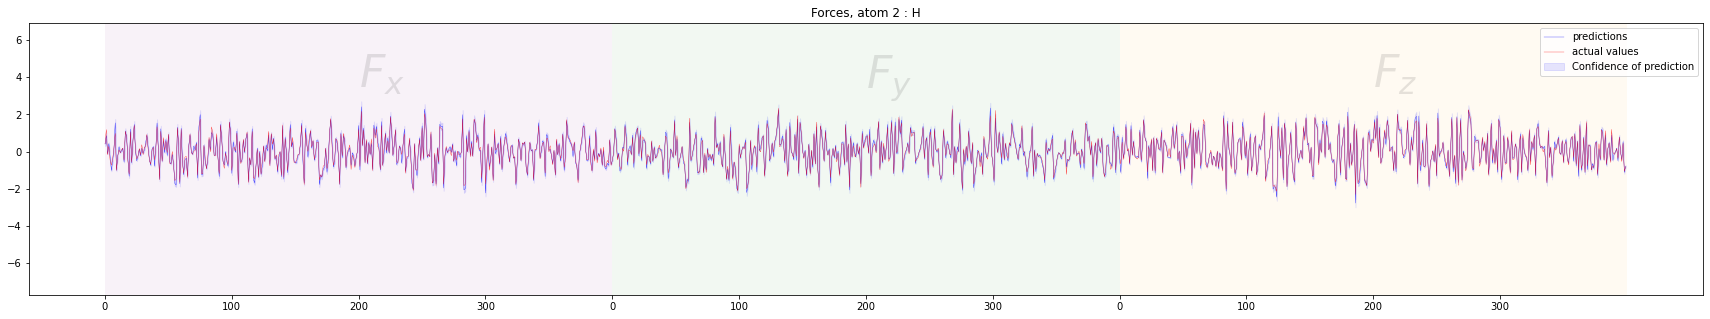

Forces MAE: 0.0943
Forces MSE: 0.0156
Cumulative uncertainty: 80.9213


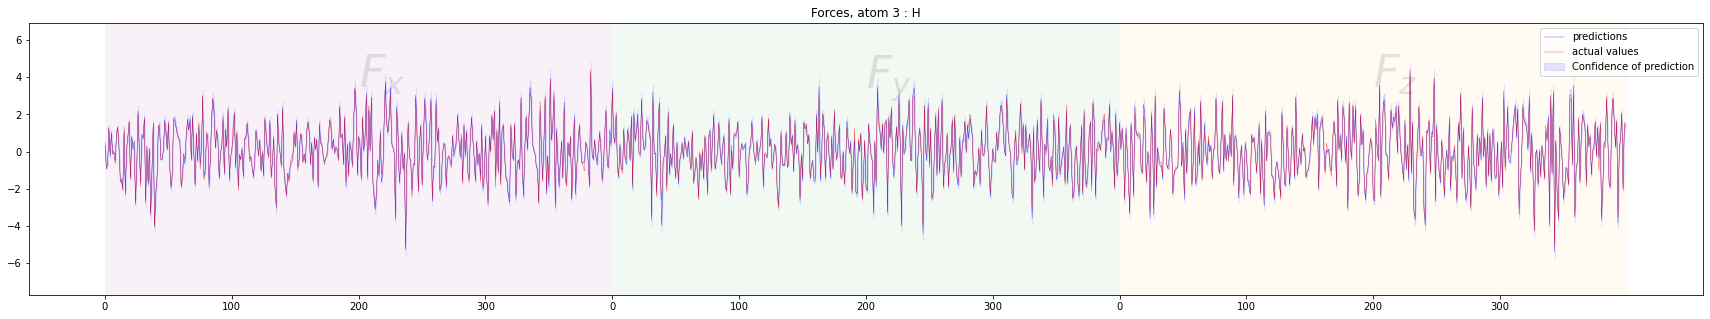

Forces MAE: 0.1355
Forces MSE: 0.0323
Cumulative uncertainty: 106.6059


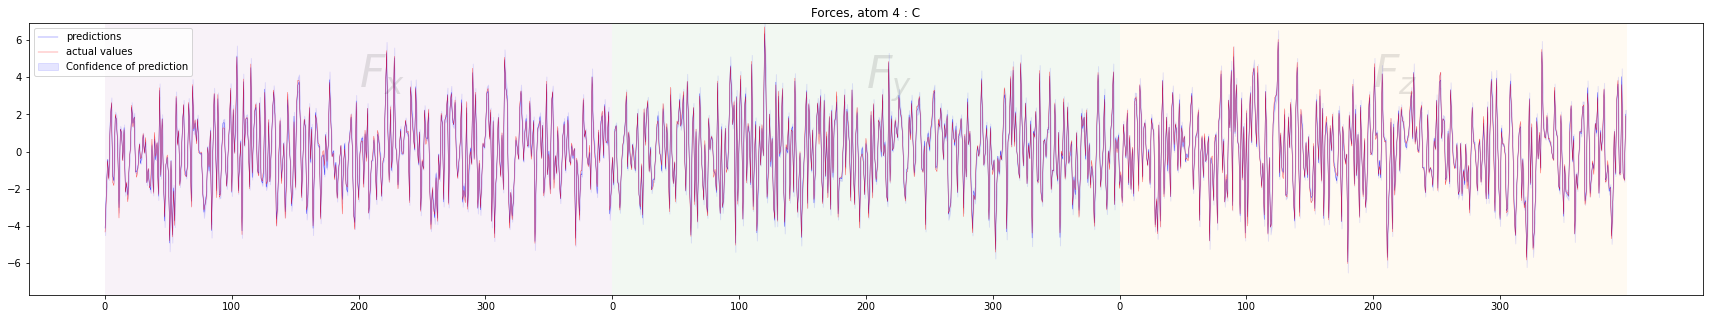

Forces MAE: 0.1248
Forces MSE: 0.0257
Cumulative uncertainty: 89.6284


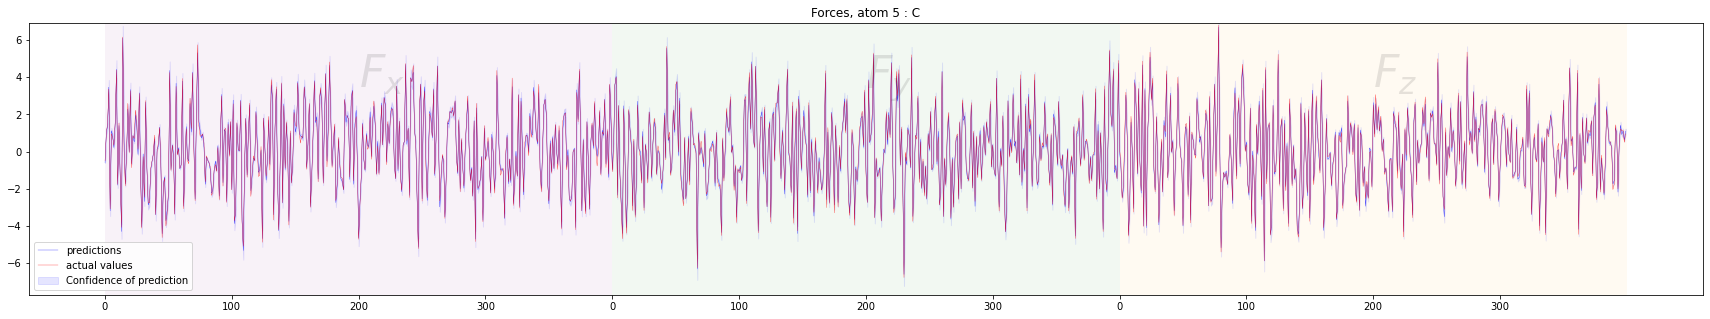

Forces MAE: 0.1209
Forces MSE: 0.0229
Cumulative uncertainty: 113.2840


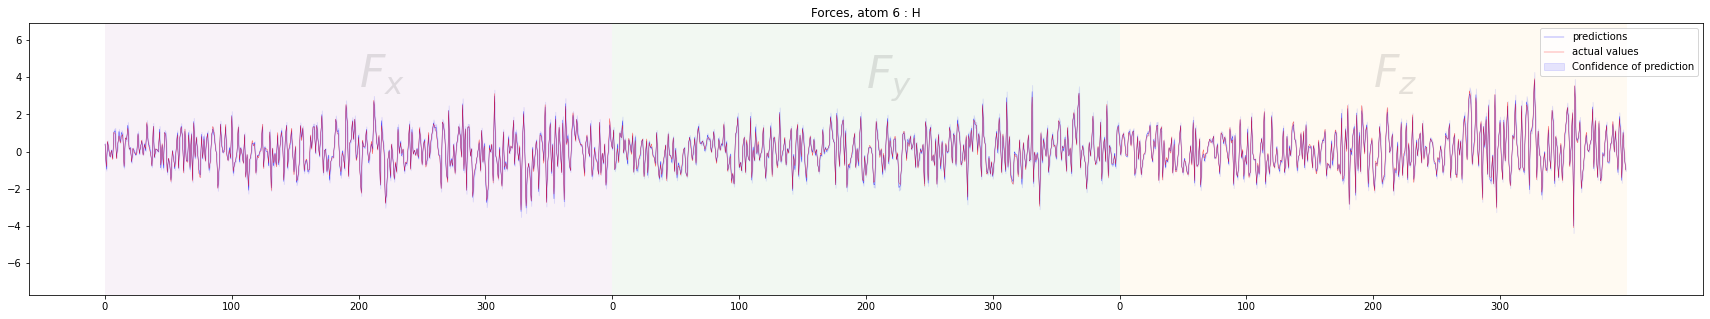

Forces MAE: 0.0755
Forces MSE: 0.0089
Cumulative uncertainty: 71.8856


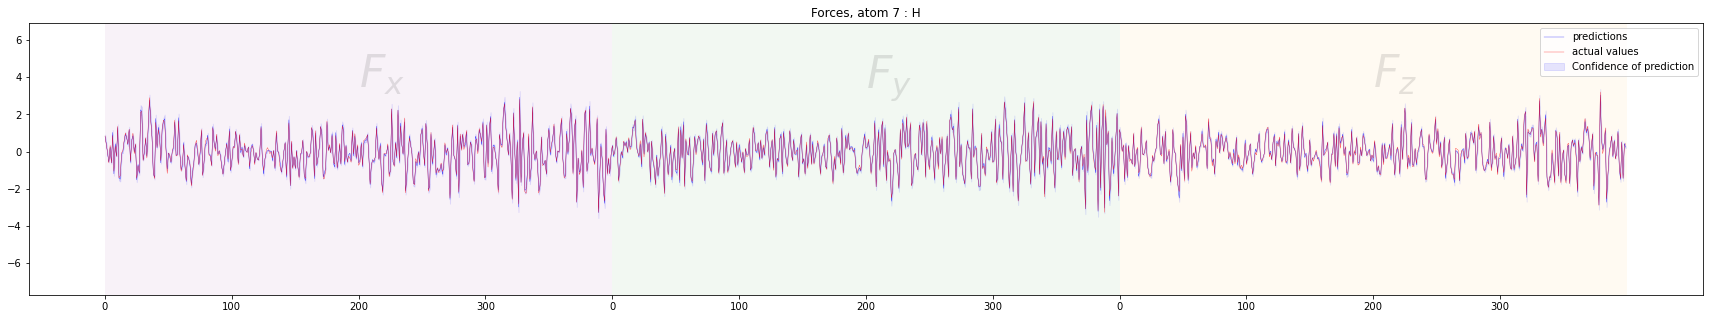

Forces MAE: 0.0772
Forces MSE: 0.0091
Cumulative uncertainty: 52.4083


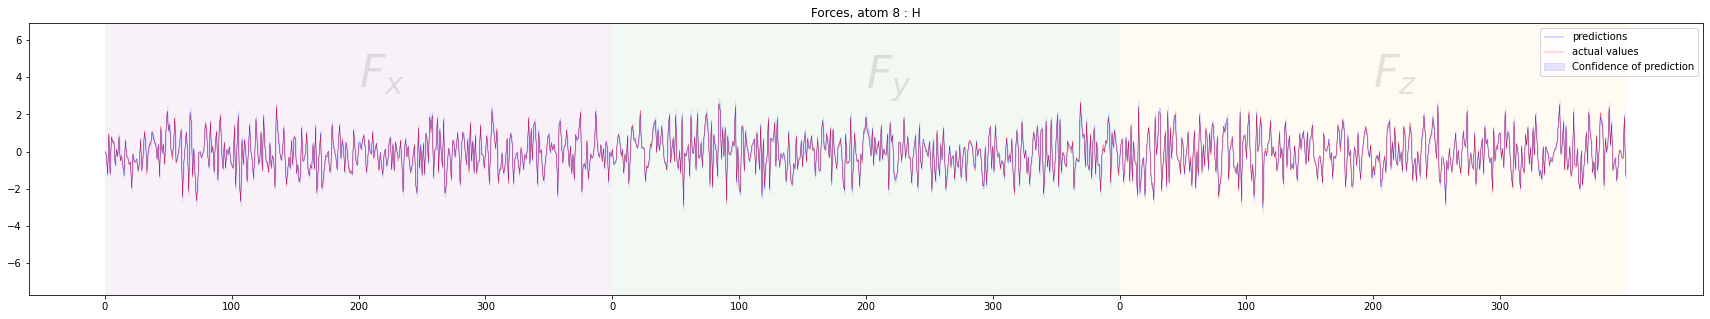

Forces MAE: 0.0755
Forces MSE: 0.0088
Cumulative uncertainty: 47.1399


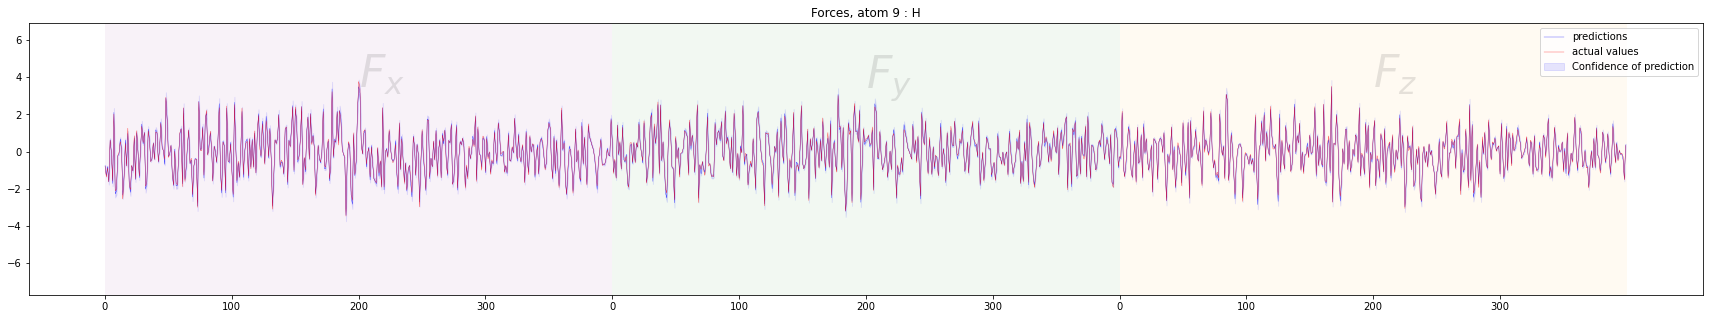

Forces MAE: 0.0719
Forces MSE: 0.0084
Cumulative uncertainty: 43.7391


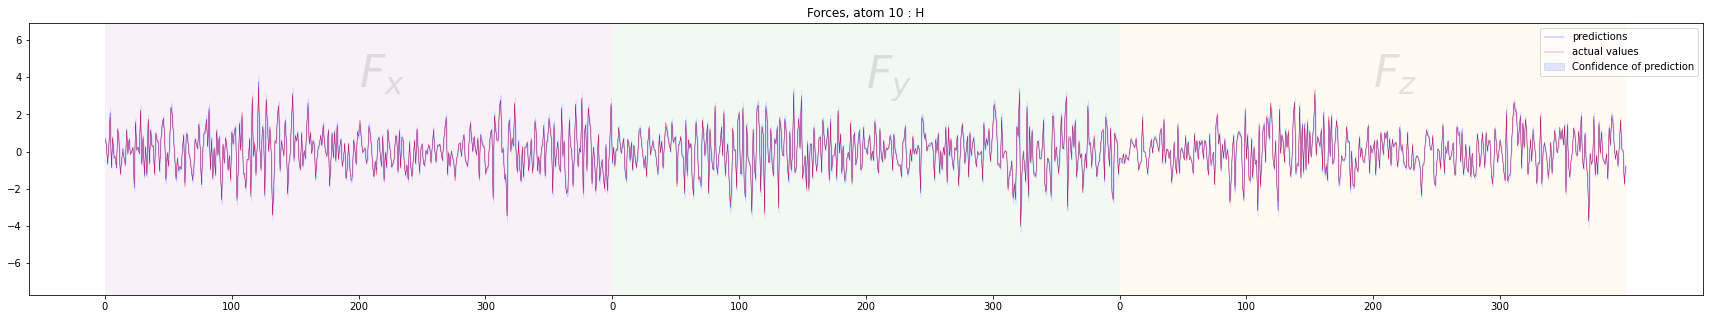

Forces MAE: 0.0724
Forces MSE: 0.0085
Cumulative uncertainty: 62.5814


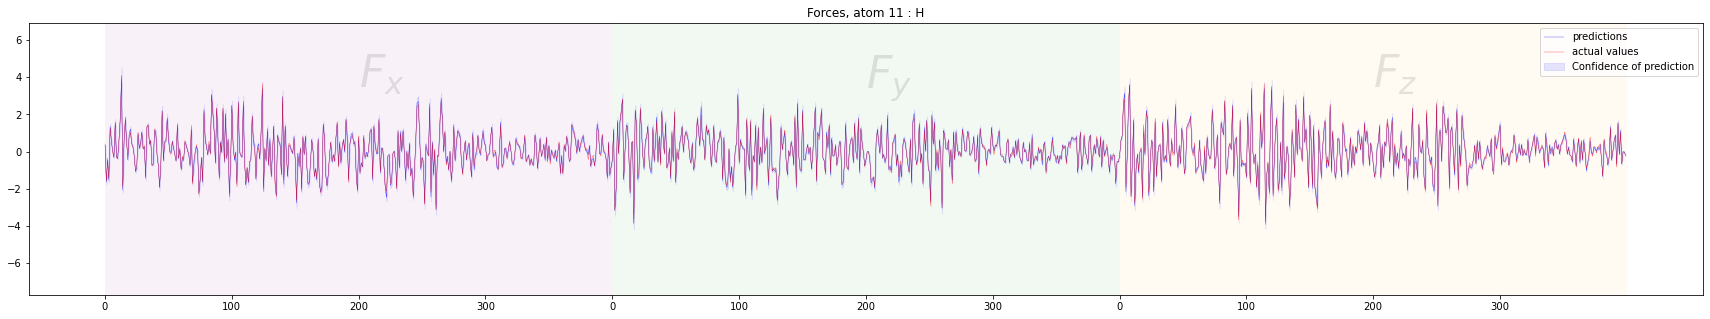

Forces MAE: 0.0797
Forces MSE: 0.0101
Cumulative uncertainty: 63.4458


In [65]:
from fande.predict import Predictor
from ase import io

# next: put this in a module function
n_molecules = fdm.n_test_structures
n_atoms = fdm.n_atoms
test_shape = fdm.test_shape
forces_energies = fdm.forces_energies
mol_traj = fdm.mol_traj

if mol_traj is None:
      mol_traj = io.read("data/dump/store/mol_trj_300K.xyz", index=":")

r_test = 0.8

n_molecules = 400
n_atoms = 12

test_X = fdm.test_X
test_Y = fdm.test_Y
test_t = test_X[:,:]
# test_t = fdm.test_X

predictor = Predictor(
      hparams,
      trainer_f,
      model_f,
      trainer_e, 
      model_e,
      test_t, 
      test_Y, 
      test_shape,
      traj,
      n_molecules,
      n_atoms,
      forces_energies,
      r_test)

predictor.predict_and_plot_energies()
predictor.predict_and_plot_forces()

### Testing ASE calc

In [66]:
%%time
from fande.ase import FandeCalc
from ase.build import molecule

from ase import io

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

traj = fdm.mol_traj #io.read("data/dump/mol_trj.xyz", index=":")
atoms = traj[0]

# atoms = molecule("CH3CH2OCH3")
fande_calc = FandeCalc(hparams, model_e, trainer_e, model_f, trainer_f)

for a in traj: a.calc=fande_calc 

print(atoms.get_potential_energy() )
print( atoms.get_forces())


TypeError: 'NoneType' object is not subscriptable

### Molecular Dynamics with Fande calculator

In [ ]:
%%capture
from fande.ase import MDRunner

atoms = fdm.mol_traj[10].copy()
atoms.calc = FandeCalc(hparams, model_e, trainer_e, model_f, trainer_f)

mdr = MDRunner(atoms, "data/dump/ase/md_test.xyz", "data/dump/ase/md_log.log")
mdr.run()

Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|███

## Model info

In [46]:
from torchinfo import summary

for name, param in final_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


summary(final_model)

ModuleNotFoundError: No module named 'torchinfo'